In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yaml
from mpl_toolkits.axes_grid1 import make_axes_locatable

import evolution
warnings.filterwarnings('ignore')

plots_folder = "./Figures/"

In [2]:
Mp  = 0.8
XFe = 15.
FeM = 0.
S = 0.0

Planet = evolution.Rocky_Planet(Mp, XFe, FeM, S)

In [3]:
evo = evolution.Evolution(Planet)
evo.run()
evo.plot(plots_folder)

5506.662639811341
5506.771794774752 5506.771794774752 5506.771794774752 0.0
5447.982080871471 5447.982080871471


AssertionError: (487777.8720155621, 31964.43979370739)

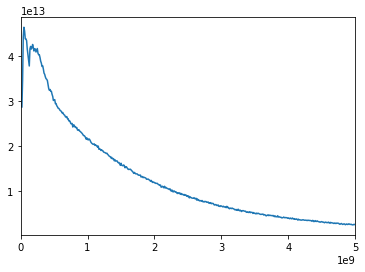

In [6]:
import pandas as pd
qcmb_ev = pd.read_csv("./Q_CMB/res_t_HS_Tm_Tb_qs_qc_M{:02d}_Fe{:02d}_#FeM{:02d}.res".format(int(10*Mp),int(XFe), int(FeM)), skipinitialspace=True, sep=" ", index_col=False,skiprows=[0])
qcmb_ev.columns = ["time", "H_rad", "T_um","T_cmb","q_surf","qcmb"]
time_vector = qcmb_ev["time"] *1e6
qcmb = qcmb_ev["qcmb"]

plt.plot(time_vector,qcmb*evo.planet.r_OC**2 * 4 * np.pi)
plt.xlim([0,5e9])
plt.show()

## Run cases for all Mp, all XFe, and a set amount of FeM (LE=0)

In [5]:
Masses = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.]
Fe = [15,25,35,45,55,65,75]
Fe_mantle = [0.00,10.,20.]
S = 0.0

M, F = np.meshgrid(Masses, Fe)
r_IC_end = np.zeros((len(Fe),len(Masses)*len(Fe_mantle)))
r_IC_beginning = np.zeros_like(r_IC_end)
MF_lifetime = np.zeros_like(r_IC_end)
Q_CMB_end = np.zeros_like(r_IC_end)
r_OC = np.zeros_like(r_IC_end)

for m,iron_mantle in enumerate(Fe_mantle):
    #print (m)
    for i, mass in enumerate(Masses):
        for j,iron in enumerate(Fe):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()
            
            r_IC_beginning[j,i+m*len(Masses)] = evo.planet.r_IC_0/1e3 
            r_IC_end[j,i+m*len(Masses)] = evo.r_IC[-1]/1e3      
            r_OC[j,i+m*len(Masses)] = evo.planet.r_OC/1e3
            MF_lifetime[j,i+m*len(Masses)] = evo.t_mf           
            Q_CMB_end[j,i+m*len(Masses)] = evo.Q_CMB[-1]        

0.8 15 0.0 0.0


AssertionError: (33917.74044322618, 31964.43979370739)

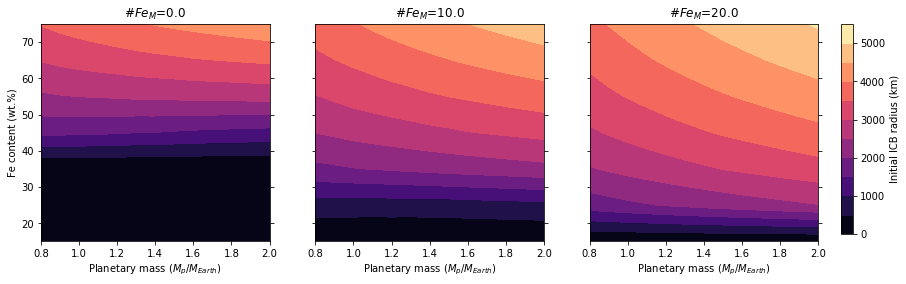

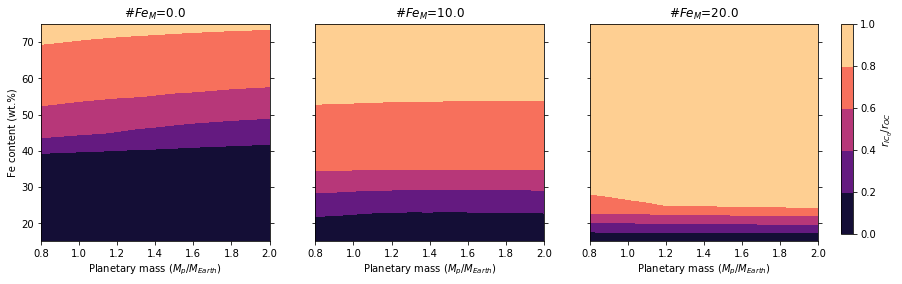

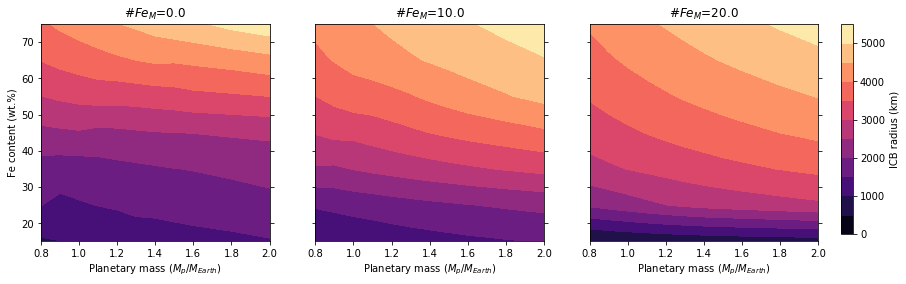

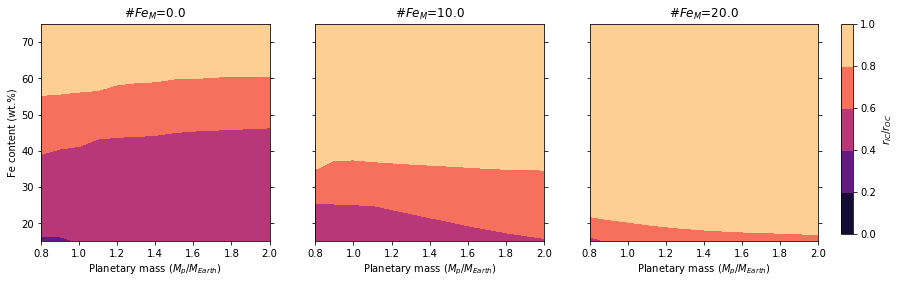

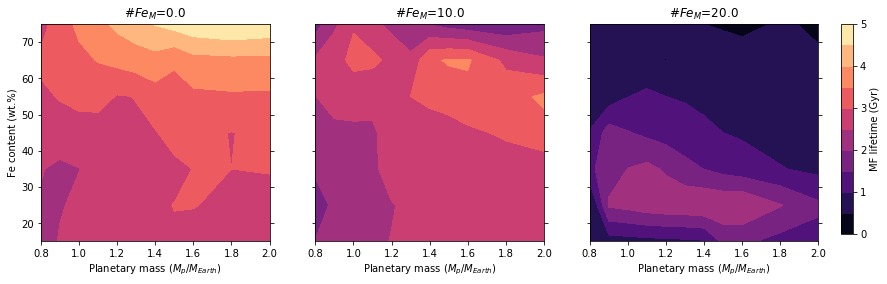

In [6]:
fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,r_IC_beginning[:,i*len(Masses):len(Masses)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("Initial ICB radius (km)")
plt.savefig(plots_folder +"r_IC0_FeM.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,r_IC_beginning[:,i*len(Masses):len(Masses)*(i+1)]/r_OC[:,i*len(Masses):len(Masses)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC_{0}}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_0_FeM.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,r_IC_end[:,i*len(Masses):len(Masses)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("ICB radius (km)")
plt.savefig(plots_folder +"r_IC_FeM.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,r_IC_end[:,i*len(Masses):len(Masses)*(i+1)]/r_OC[:,i*len(Masses):len(Masses)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_FeM.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_MF = np.linspace(0, 5, 11)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,MF_lifetime[:,i*len(Masses):len(Masses)*(i+1)],levels_MF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("MF lifetime (Gyr)")
plt.savefig(plots_folder +"MF_lifetime_FeM.pdf", bbox_inches="tight")
plt.show()

In [7]:
Fe_mantle = [0.,5.,10.,15.,20.]
Masses = [0.8, 1.0, 1.5, 2.]
Fe = 45
LE = [0,0.05]

TL0 = np.zeros((len(Fe_mantle),len(Masses)*len(LE)),dtype=np.float64)
T0 = np.zeros((len(Fe_mantle),len(Masses)*len(LE)),dtype=np.float64)

for m, light_elements in enumerate(LE):
    for i, mass in enumerate(Masses):
        for j,iron_mantle in enumerate(Fe_mantle):
            Mp = mass
            XFe = Fe
            S = light_elements
            FeM = iron_mantle
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()

            TL0[j,i+m*len(Masses)] = evo.planet.TL0 
            T0[j,i+m*len(Masses)] = evo.planet.T0

0.8 45 0.0
0.8 45 5.0
0.8 45 10.0
0.8 45 15.0
0.8 45 20.0
1.0 45 0.0
1.0 45 5.0
1.0 45 10.0
1.0 45 15.0
1.0 45 20.0
1.5 45 0.0
1.5 45 5.0
1.5 45 10.0
1.5 45 15.0
1.5 45 20.0
2.0 45 0.0
2.0 45 5.0
2.0 45 10.0
2.0 45 15.0
2.0 45 20.0
0.8 45 0.0
0.8 45 5.0
0.8 45 10.0
0.8 45 15.0
0.8 45 20.0
1.0 45 0.0
1.0 45 5.0
1.0 45 10.0
1.0 45 15.0
1.0 45 20.0
1.5 45 0.0
1.5 45 5.0
1.5 45 10.0
1.5 45 15.0
1.5 45 20.0
2.0 45 0.0
2.0 45 5.0
2.0 45 10.0
2.0 45 15.0
2.0 45 20.0


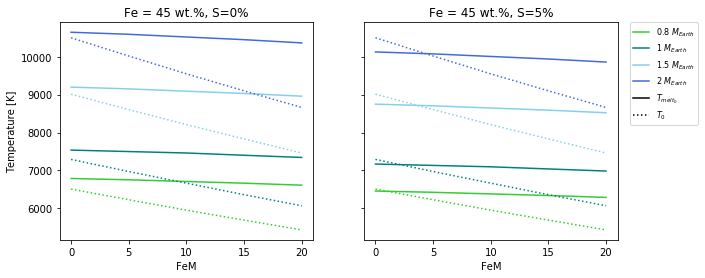

In [8]:
label=["0.8 $M_{Earth}$",'1 $M_{Earth}$','1.5 $M_{Earth}$','2 $M_{Earth}$']
color=["limegreen","teal","skyblue","royalblue"]
fig, ax = plt.subplots(1, 2, figsize=[10,4],sharey=True)
for i in range(len(Masses)):
    ax[0].plot(Fe_mantle,TL0[:,i],color=color[i])
    ax[0].plot(Fe_mantle,T0[:,i],linestyle=':',color=color[i])
    ax[1].plot(Fe_mantle,TL0[:,i+len(Masses)],label=label[i],color=color[i])
    ax[1].plot(Fe_mantle,T0[:,i+len(Masses)],linestyle=':',color=color[i])

ax[0].set_xlabel('FeM')
ax[1].set_xlabel('FeM')
ax[0].set_ylabel('Temperature [K]')
ax[0].set_title('Fe = 45 wt.%, S=0%')
ax[1].set_title('Fe = 45 wt.%, S=5%')
handles, labels = ax[1].get_legend_handles_labels()
display = (0,1,2,3,4)
simArtist = plt.Line2D((0,1),(0,0), color='k')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')
ax[1].legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['$T_{melt_{0}}$','$T_{0}$'],bbox_to_anchor=(1.05, 1),borderaxespad=0.,fontsize=8)
plt.savefig(plots_folder +"T0_Tmelt.pdf", bbox_inches="tight")
plt.show()

## Run cases for all XFe, all FeM, and a set amount of Mp (LE=0)

In [9]:
Masses_ = [0.8, 1.0, 1.5, 2.]
Fe = [15,25,35,45,55,65,75]
Fe_mantle_ = [0.,5.,10.,15.,20.]
S = 0.0

FE, FM = np.meshgrid(Fe,Fe_mantle_)
r_IC_end_M = np.zeros((len(Fe_mantle_),len(Masses_)*len(Fe)))
r_IC_beginning_M = np.zeros_like(r_IC_end_M)
MF_lifetime_M = np.zeros_like(r_IC_end_M)
Q_CMB_end_M = np.zeros_like(r_IC_end_M)
r_OC_M = np.zeros_like(r_IC_end_M)

for m,mass in enumerate(Masses_):
    for i, iron in enumerate(Fe):
        for j,iron_mantle in enumerate(Fe_mantle_):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)
            evo.run()
            r_IC_beginning_M[j,i+m*len(Fe)] = evo.planet.r_IC_0/1e3 
            r_IC_end_M[j,i+m*len(Fe)] = evo.r_IC[-1]/1e3      
            r_OC_M[j,i+m*len(Fe)] = evo.planet.r_OC/1e3
            MF_lifetime_M[j,i+m*len(Fe)] = evo.t_mf           
            Q_CMB_end_M[j,i+m*len(Fe)] = evo.Q_CMB[-1] 

0.8 15 0.0
0.8 15 5.0
0.8 15 10.0
0.8 15 15.0
0.8 15 20.0
0.8 25 0.0
0.8 25 5.0
0.8 25 10.0
0.8 25 15.0
0.8 25 20.0
0.8 35 0.0
0.8 35 5.0
0.8 35 10.0
0.8 35 15.0
0.8 35 20.0
0.8 45 0.0
0.8 45 5.0
0.8 45 10.0
0.8 45 15.0
0.8 45 20.0
0.8 55 0.0
0.8 55 5.0
0.8 55 10.0
0.8 55 15.0
0.8 55 20.0
0.8 65 0.0
0.8 65 5.0
0.8 65 10.0
0.8 65 15.0
0.8 65 20.0
0.8 75 0.0
0.8 75 5.0
0.8 75 10.0
0.8 75 15.0
0.8 75 20.0
1.0 15 0.0
1.0 15 5.0
1.0 15 10.0
1.0 15 15.0
1.0 15 20.0
1.0 25 0.0
1.0 25 5.0
1.0 25 10.0
1.0 25 15.0
1.0 25 20.0
1.0 35 0.0
1.0 35 5.0
1.0 35 10.0
1.0 35 15.0
1.0 35 20.0
1.0 45 0.0
1.0 45 5.0
1.0 45 10.0
1.0 45 15.0
1.0 45 20.0
1.0 55 0.0
1.0 55 5.0
1.0 55 10.0
1.0 55 15.0
1.0 55 20.0
1.0 65 0.0
1.0 65 5.0
1.0 65 10.0
1.0 65 15.0
1.0 65 20.0
1.0 75 0.0
1.0 75 5.0
1.0 75 10.0
1.0 75 15.0
1.0 75 20.0
1.5 15 0.0
1.5 15 5.0
1.5 15 10.0
1.5 15 15.0
1.5 15 20.0
1.5 25 0.0
1.5 25 5.0
1.5 25 10.0
1.5 25 15.0
1.5 25 20.0
1.5 35 0.0
1.5 35 5.0
1.5 35 10.0
1.5 35 15.0
1.5 35 20.0
1.5 45 0.0
1.5

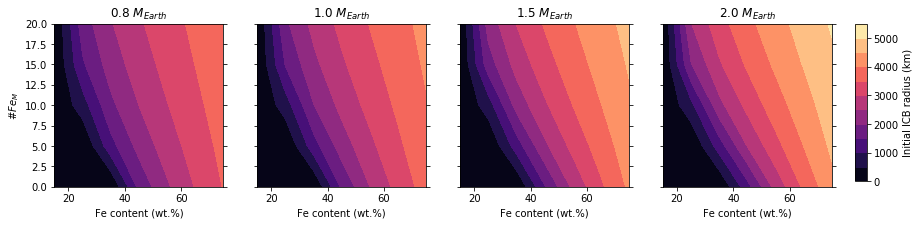

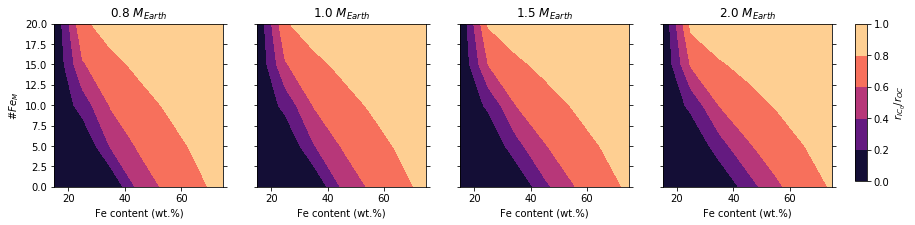

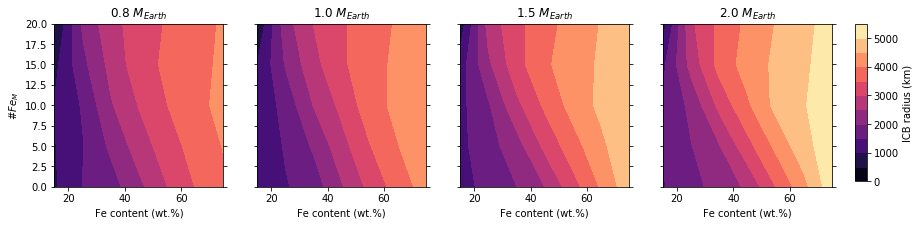

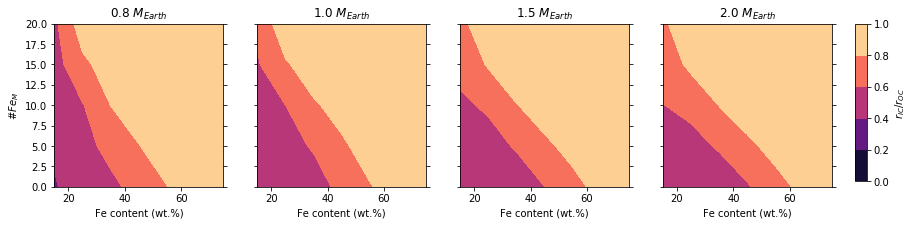

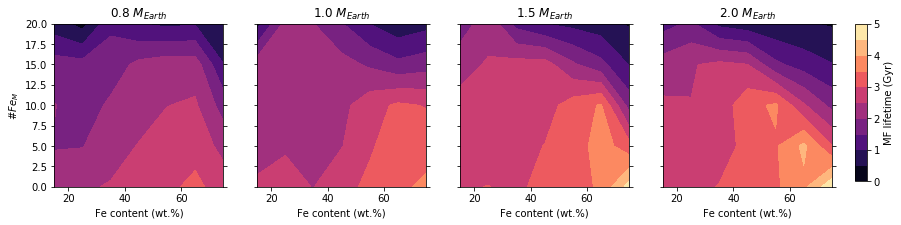

In [10]:
fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,r_IC_beginning_M[:,i*len(Fe):len(Fe)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("Initial ICB radius (km)")
plt.savefig(plots_folder +"r_IC_Mp.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,r_IC_beginning_M[:,i*len(Fe):len(Fe)*(i+1)]/r_OC_M[:,i*len(Fe):len(Fe)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
         ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC_{0}}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_Mp.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,r_IC_end_M[:,i*len(Fe):len(Fe)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("ICB radius (km)")
plt.savefig(plots_folder +"r_IC_Mp.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,r_IC_end_M[:,i*len(Fe):len(Fe)*(i+1)]/r_OC_M[:,i*len(Fe):len(Fe)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
         ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_Mp.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_MF = np.linspace(0, 5, 11)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,MF_lifetime_M[:,i*len(Fe):len(Fe)*(i+1)],levels_MF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("MF lifetime (Gyr)")
plt.savefig(plots_folder +"MF_lifetime_Mp.pdf", bbox_inches="tight")
plt.show()

## Run cases for all Mp, all XFe, and a set amount of light elements (FeM=0)

In [21]:
Masses_S = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.]
Fe_S = [15,25,35,45,55,65,75]
FeM_S = 0.0
LE_S = [0.0,0.05,0.1]

M_S, F_S = np.meshgrid(Masses_S, Fe_S)
r_IC_end_S = np.zeros((len(Fe_S),len(Masses_S)*len(LE_S)))
r_IC_beginning_S = np.zeros_like(r_IC_end_S)
MF_lifetime_S = np.zeros_like(r_IC_end_S)
Q_CMB_end_S = np.zeros_like(r_IC_end_S)
r_OC_S = np.zeros_like(r_IC_end_S)

for m,light_elements in enumerate(LE_S):
    for i, mass in enumerate(Masses_S):
        for j,iron in enumerate(Fe_S):
            Mp = mass
            XFe = iron
            S = light_elements
            FeM = FeM_S
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)
            evo.run()
            
            r_IC_beginning_S[j,i+m*len(Masses_S)] = evo.planet.r_IC_0/1e3
            r_IC_end_S[j,i+m*len(Masses_S)] = evo.r_IC[-1]/1e3
            print (r_IC_end_S[j,i+m*len(Masses_S)])
            if r_IC_end_S[j,i+m*len(Masses_S)]<0:
                break
            r_OC_S[j,i+m*len(Masses_S)] = evo.planet.r_OC/1e3
            MF_lifetime_S[j,i+m*len(Masses_S)] = evo.t_mf           
            Q_CMB_end_S[j,i+m*len(Masses_S)] = evo.Q_CMB[-1]        

934.1643843191108
1509.5926872111856
1780.5128812711264
2372.3608724511455
2990.312168776415
3513.1692980225803
3920.8996663245716
991.2883805572911
1384.4752239643333
1735.2055068047973
2415.7828761343385
3080.0917848519903
3635.4645602916444
4084.3806249701215
1050.4565245027588
1457.6246950446882
1741.0898113680755
2453.9205340247745
3146.1945043483584
3734.6689152686386
4215.852914490975
1090.1322619552427
1509.1723832652908
1809.6984409744036
2370.861422689062
3207.551010413878
3829.8958551605247
4346.316626529192
1144.0720190695552
1554.5208332826237
1864.4882181960697
2401.7364353843486
3186.3032079969194
3918.5192887992634
4485.199142691409
1201.374559180384
1637.5291837851366
1906.625719247294
2441.976464743209
3214.313054454648
4000.270227782354
4584.159071378384
1246.1008226698902
1641.8809312264527
1949.8704882863115
2481.2783553065524
3254.515089838297
4074.1580690388028
4712.324511304171
1285.6997657530342
1684.9671056817535
1990.743389831834
2496.191820387229
3299.116598

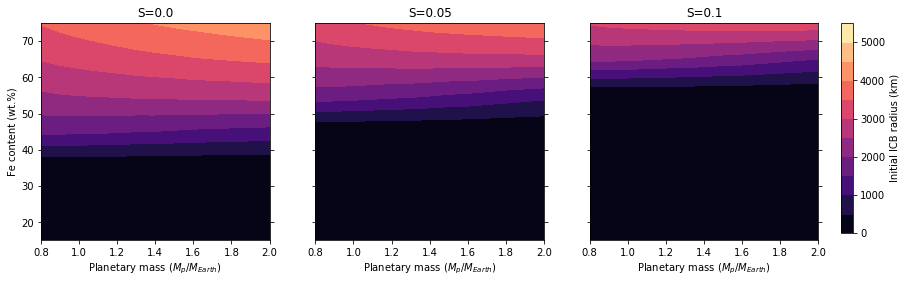

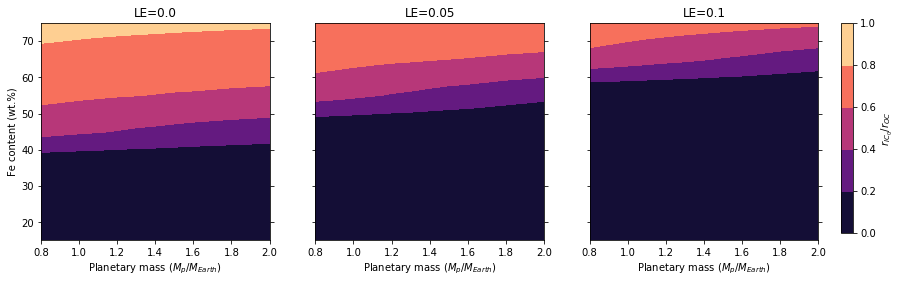

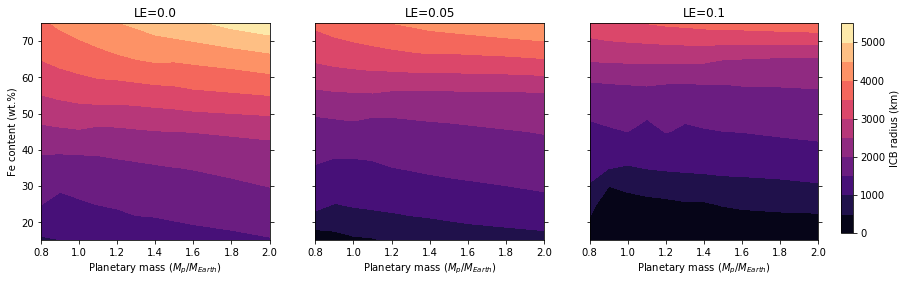

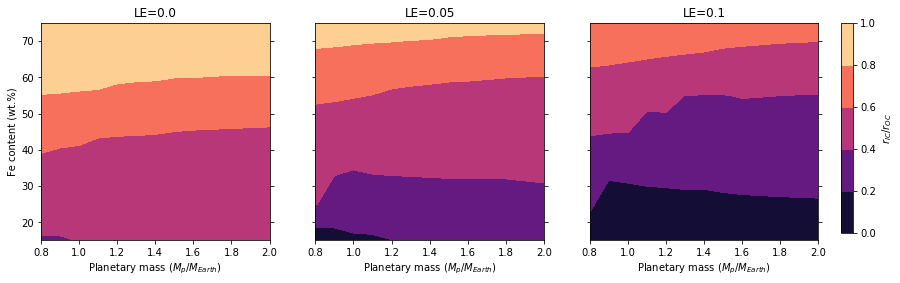

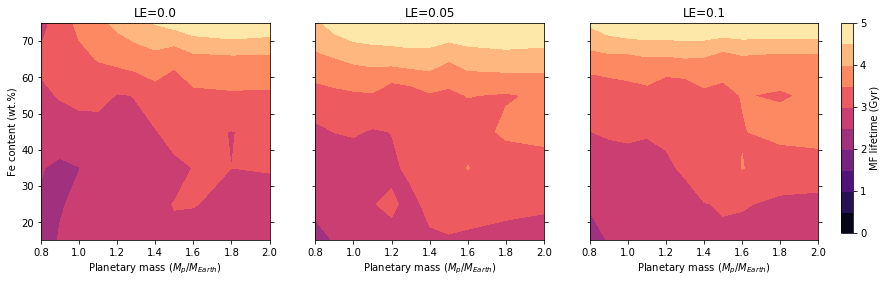

In [22]:
fig, ax = plt.subplots(1, len(LE_S), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(LE_S)):
    sc = ax[i].contourf(M_S,F_S,r_IC_beginning_S[:,i*len(Masses_S):len(Masses_S)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('S={}'.format(LE_S[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("Initial ICB radius (km)")
plt.savefig(plots_folder +"r_IC0_FeM_S.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(LE_S), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(LE_S)):
    sc = ax[i].contourf(M_S,F_S,r_IC_beginning_S[:,i*len(Masses_S):len(Masses_S)*(i+1)]/r_OC_S[:,i*len(Masses_S):len(Masses_S)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('LE={}'.format(LE_S[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC_{0}}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_0_S.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(LE_S), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(LE_S)):
    sc = ax[i].contourf(M_S,F_S,r_IC_end_S[:,i*len(Masses_S):len(Masses_S)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('LE={}'.format(LE_S[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("ICB radius (km)")
plt.savefig(plots_folder +"r_IC_S.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(LE_S), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(LE_S)):
    sc = ax[i].contourf(M_S,F_S,r_IC_end_S[:,i*len(Masses_S):len(Masses_S)*(i+1)]/r_OC_S[:,i*len(Masses_S):len(Masses_S)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('LE={}'.format(LE_S[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_S.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(LE_S), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_MF = np.linspace(0, 5, 11)
for i in range(len(LE_S)):
    sc = ax[i].contourf(M_S,F_S,MF_lifetime_S[:,i*len(Masses_S):len(Masses_S)*(i+1)],levels_MF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('LE={}'.format(LE_S[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("MF lifetime (Gyr)")
plt.savefig(plots_folder +"MF_lifetime_S.pdf", bbox_inches="tight")
plt.show()

## Run cases for all XFe, all LE, and a set amount of masses (FeM=0)

In [16]:
Masses_SM = [0.8, 1.0, 1.5, 2.]
Fe_SM = [15,25,35,45,55,65,75]
Fe_mantle_SM = 0.
LE_SM = [0.0,0.05,0.1]

F_SM, M_SM = np.meshgrid(Fe_SM,LE_SM)
r_IC_end_SM = np.zeros((len(LE_SM),len(Masses_SM)*len(Fe_SM)))
r_IC_beginning_SM = np.zeros_like(r_IC_end_SM)
MF_lifetime_SM = np.zeros_like(r_IC_end_SM)
Q_CMB_end_SM = np.zeros_like(r_IC_end_SM)
r_OC_SM = np.zeros_like(r_IC_end_SM)

for m,mass in enumerate(Masses_SM):
    for i, iron in enumerate(Fe_SM):
        for j,light_elements in enumerate(LE_SM):
            Mp = mass
            XFe = iron
            FeM = Fe_mantle_SM
            S = light_elements
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)
            evo.run()
            r_IC_beginning_SM[j,i+m*len(Fe_SM)] = evo.planet.r_IC_0/1e3 
            r_IC_end_SM[j,i+m*len(Fe_SM)] = evo.r_IC[-1]/1e3      
            r_OC_SM[j,i+m*len(Fe_SM)] = evo.planet.r_OC/1e3
            MF_lifetime_SM[j,i+m*len(Fe_SM)] = evo.t_mf           
            Q_CMB_end_SM[j,i+m*len(Fe_SM)] = evo.Q_CMB[-1]

0.8 15 0.0 0.0
0.8 15 0.0 0.05
0.8 15 0.0 0.1
0.8 25 0.0 0.0
0.8 25 0.0 0.05
0.8 25 0.0 0.1
0.8 35 0.0 0.0
0.8 35 0.0 0.05
0.8 35 0.0 0.1
0.8 45 0.0 0.0
0.8 45 0.0 0.05
0.8 45 0.0 0.1
0.8 55 0.0 0.0
0.8 55 0.0 0.05
0.8 55 0.0 0.1
0.8 65 0.0 0.0
0.8 65 0.0 0.05
0.8 65 0.0 0.1
0.8 75 0.0 0.0
0.8 75 0.0 0.05
0.8 75 0.0 0.1
1.0 15 0.0 0.0
1.0 15 0.0 0.05
1.0 15 0.0 0.1
1.0 25 0.0 0.0
1.0 25 0.0 0.05
1.0 25 0.0 0.1
1.0 35 0.0 0.0
1.0 35 0.0 0.05
1.0 35 0.0 0.1
1.0 45 0.0 0.0
1.0 45 0.0 0.05
1.0 45 0.0 0.1
1.0 55 0.0 0.0
1.0 55 0.0 0.05
1.0 55 0.0 0.1
1.0 65 0.0 0.0
1.0 65 0.0 0.05
1.0 65 0.0 0.1
1.0 75 0.0 0.0
1.0 75 0.0 0.05
1.0 75 0.0 0.1
1.5 15 0.0 0.0
1.5 15 0.0 0.05
1.5 15 0.0 0.1
1.5 25 0.0 0.0
1.5 25 0.0 0.05
1.5 25 0.0 0.1
1.5 35 0.0 0.0
1.5 35 0.0 0.05
1.5 35 0.0 0.1
1.5 45 0.0 0.0
1.5 45 0.0 0.05
1.5 45 0.0 0.1
1.5 55 0.0 0.0
1.5 55 0.0 0.05
1.5 55 0.0 0.1
1.5 65 0.0 0.0
1.5 65 0.0 0.05
1.5 65 0.0 0.1
1.5 75 0.0 0.0
1.5 75 0.0 0.05
1.5 75 0.0 0.1
2.0 15 0.0 0.0
2.0 15 0.0 0.05
2.0

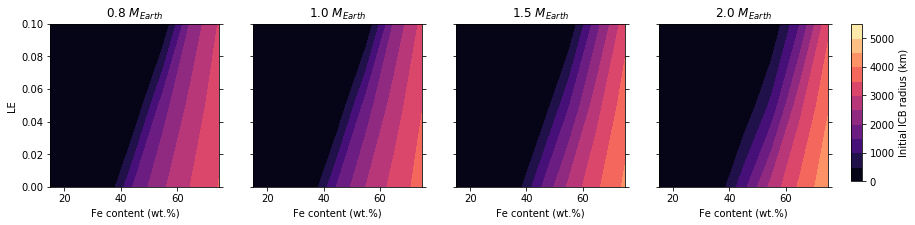

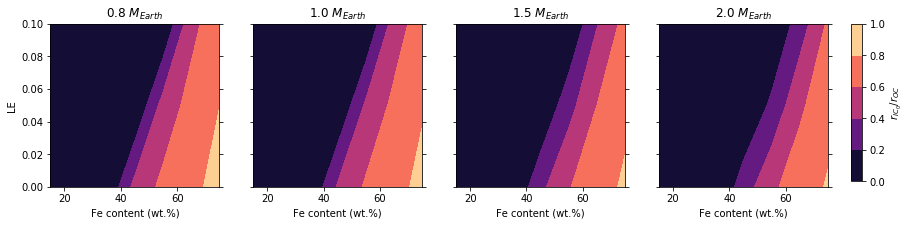

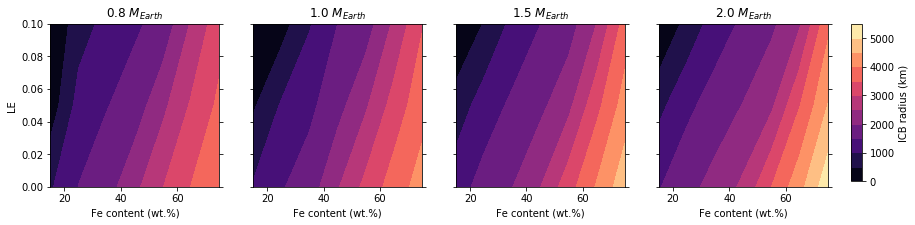

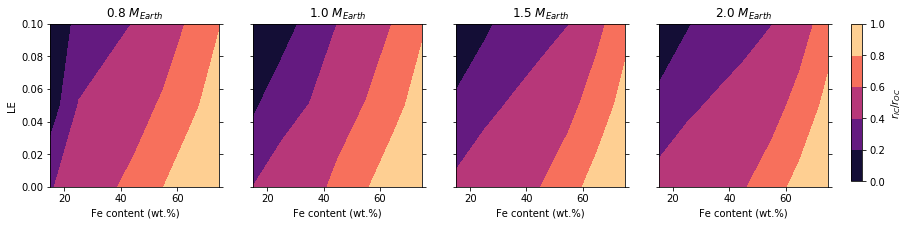

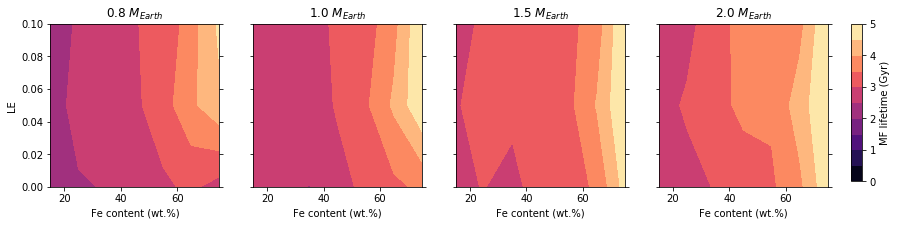

In [18]:
fig, ax = plt.subplots(1, len(Masses_SM), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Masses_SM)):
    sc = ax[i].contourf(F_SM,M_SM,r_IC_beginning_SM[:,i*len(Fe_SM):len(Fe_SM)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("LE")
    ax[i].set_title("{:.1f}".format(Masses_SM[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("Initial ICB radius (km)")
plt.savefig(plots_folder +"r_IC_MpS.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_SM), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(Masses_SM)):
    sc = ax[i].contourf(F_SM,M_SM,r_IC_beginning_SM[:,i*len(Fe_SM):len(Fe_SM)*(i+1)]/r_OC_SM[:,i*len(Fe_SM):len(Fe_SM)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
         ax[i].set_ylabel("LE")
    ax[i].set_title("{:.1f}".format(Masses_SM[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC_{0}}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_MpS.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_SM), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Masses_SM)):
    sc = ax[i].contourf(F_SM,M_SM,r_IC_end_SM[:,i*len(Fe_SM):len(Fe_SM)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("LE")
    ax[i].set_title("{:.1f}".format(Masses_SM[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("ICB radius (km)")
plt.savefig(plots_folder +"r_IC_MpS.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_SM), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 6)
for i in range(len(Masses_SM)):
    sc = ax[i].contourf(F_SM,M_SM,r_IC_end_SM[:,i*len(Fe_SM):len(Fe_SM)*(i+1)]/r_OC_SM[:,i*len(Fe_SM):len(Fe_SM)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
         ax[i].set_ylabel("LE")
    ax[i].set_title("{:.1f}".format(Masses_SM[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_MpS.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_SM), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_MF = np.linspace(0, 5, 11)
for i in range(len(Masses_SM)):
    sc = ax[i].contourf(F_SM,M_SM,MF_lifetime_SM[:,i*len(Fe_SM):len(Fe_SM)*(i+1)],levels_MF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("LE")
    ax[i].set_title("{:.1f}".format(Masses_SM[i]) + r" $M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("MF lifetime (Gyr)")
plt.savefig(plots_folder +"MF_lifetime_MpS.pdf", bbox_inches="tight")
plt.show()